# Open Street Map

By making use of the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library we can fetch [OpenStreetMap](https://www.openstreetmap.org/) data and use it in [MGSurvE](https://github.com/Chipdelmal/MGSurvE)! This time, we will start by loading the library and setting up some of its internal parameters:

In [93]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Load libraries --------------------------------------------------------------
import osmnx as ox
import numpy as np
import pandas as pd
from math import exp
from copy import deepcopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
ox.settings.log_console=False
ox.settings.use_cache=True
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('Banfora', './out/')
srv.makeFolder(OUT_PTH)

## Downloading Buildings Footprints

In this example, we will download the data of a section of Banfora, Burkina Faso. To do this, we will center our reference point at the `(10.63524, -4.75195)` coordinates and set an altitude of `250` meters:

In [94]:
(COORDS, DIST) = ((10.63524, -4.75195), 250)
# Scrape building footprints to dataframe -------------------------------------
BLD = ox.features.features_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
# Extend the original dataframe to contain the centroids of geometries --------
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


The `BLD` dataframe contains all the information we need to generate a map of the location and we can, additionally, plot the roads by projecting the `NTW` graph:

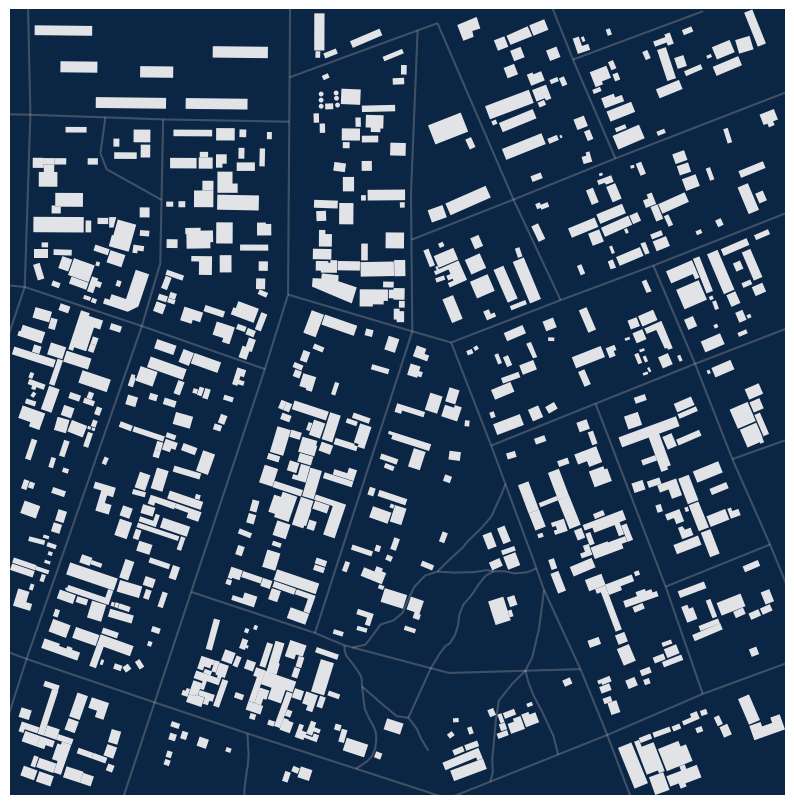

In [95]:
STYLE_BG = {'color': '#0b2545'}
STYLE_BD = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
# Project and plot map --------------------------------------------------------
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

## Generating MGSurvE Landscape

If we wanted to make use of our data in [MGSurvE](https://github.com/Chipdelmal/MGSurvE), one simple way we can go about it is by using the `centroid_lon` and `centroid_lat` to generate our migration matrix and landscape:

In [96]:
lonLats = np.array(list(zip(BLD['centroid_lon'], BLD['centroid_lat'])))
migDst = srv.calcDistanceMatrix(lonLats, distFun=srv.haversineDistance)

This time, we will define a custom exponential kernel. To do this we just need to define a function that takes the distance matrix as an argument, applies a function upon it based on the distance between every pair-wise combination of points (an exponential decay one, in this case), and returns a row-normalized migration probability matrix:

In [97]:
# Defining our custom migration kernel ----------------------------------------
def exponentialKernel(distMat, decay):
    coordsNum = len(distMat)
    migrMat = np.empty((coordsNum, coordsNum))
    for (i, row) in enumerate(distMat):
        for (j, dst) in enumerate(row):
            migrMat[i][j] = exp(-decay*dst)
        for j in range(len(row)):
            if np.isnan(migrMat[i][j]):
                migrMat[i][j] = 0
    tauN = normalize(migrMat, axis=1, norm='l1')
    return np.array(tauN)
# Calculating the full migration matrix ---------------------------------------
MEAN_LIFETIME_DISPERSAL = 25
migMat = exponentialKernel(migDst, 1/MEAN_LIFETIME_DISPERSAL)

We now generate our sites dataframe:

In [98]:
# Generate sites dataframe ----------------------------------------------------
sites = pd.DataFrame(lonLats, columns=['lon', 'lat'])
sites['t'] = [0]*sites.shape[0]
# Get the bounding box and centroid -------------------------------------------
BBOX = (
    (min(sites['lon']), max(sites['lon'])),
    (min(sites['lat']), max(sites['lat']))
)

And define the traps we want to optimize:

In [99]:
TRPS_NUM = 5
(initLon, initLat) = (
    sites.iloc[0]['lon']*TRPS_NUM, 
    sites.iloc[0]['lat']*TRPS_NUM
)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid, 'lon': initLon, 'lat': initLat, 
    't': [0]*TRPS_NUM, 'f': [0]*TRPS_NUM
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

With these pieces in place, we can now define our landscape object:

In [100]:
lnd = srv.Landscape(
    sites, 
    migrationMatrix=migMat, kernelFunction=exponentialKernel, 
    distanceFunction=srv.haversineDistance,
    kernelParams={'decay': 1/MEAN_LIFETIME_DISPERSAL},
    traps=traps, trapsKernels=tKer, trapsRadii=[0.250, 0.125, 0.100],
    landLimits=BBOX
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/MGSurvE/kernels.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = A * math.exp(-b * dist)


## Optimizing 

We will run discrete optimization upon our landscape as follows:

In [101]:
GENS = 200
VERBOSE = True
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
lndGA = deepcopy(lnd)
# Running GA and exporting results --------------------------------------------
(lndDO, logbookDO) = srv.optimizeDiscreteTrapsGA(
    lndGA, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)
srv.exportLog(logbookDO, OUT_PTH, '{}_LOG_DO'.format(ID))
srv.dumpLandscape(lndDO, OUT_PTH, '{}_LND_DO'.format(ID), fExt='pkl')

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    	max    	std    	best	traps                   
0  	75    	32.9941	53.2878	144.388	17.4358	26  	[701, 571, 69, 401, 405]
1  	36    	31.4758	43.4569	78.97  	8.04524	32  	[307, 691, 70, 230, 633]
2  	46    	31.4758	40.7656	58.2666	6.07441	1   	[307, 691, 70, 230, 633]
3  	47    	31.4758	39.9623	89.4346	9.15016	48  	[307, 691, 70, 230, 633]
4  	46    	31.3282	38.6606	86.8688	7.63413	66  	[323, 502, 70, 228, 538]
5  	46    	30.8773	39.6947	83.7081	9.95573	44  	[701, 571, 69, 226, 98] 
6  	51    	30.4188	37.2669	66.7405	6.86252	61  	[701, 571, 69, 401, 98] 
7  	46    	28.5847	37.3647	76.1816	8.32063	12  	[307, 571, 69, 230, 98] 
8  	36    	28.5847	34.8468	55.5916	5.99249	20  	[307, 571, 69, 230, 98] 
9  	35    	28.5847	33.5321	53.5124	5.01465	16  	[307, 571, 69, 230, 98] 
10 	42    	28.5847	35.4621	97.2003	10.218 	8   	[307, 571, 69, 230, 98] 
11 	48    	28.5847	35.1309	73.6678	8.78529	8   	[307, 571, 69, 230, 98] 
12 	42    	27.8636	32.9657	66.5072	7.40594	29  	[30

And plot our results!

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


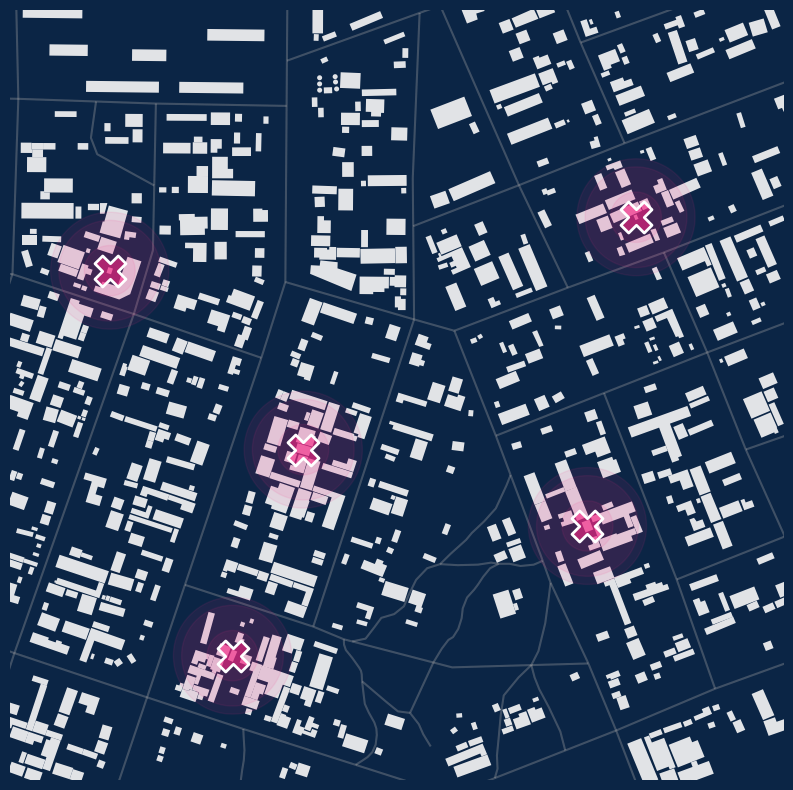

In [102]:
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lndDO.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])
fig.savefig(
    os.path.join(OUT_PTH, '{}DO.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

Running the continuous case is also easy!

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg   	max    	std    	best	traps                                                                                                                                                                                                 
0  	62    	35.6199	53.022	93.1251	13.4344	8   	[-4.753388470002695, 10.63424345167456, -4.75065459732664, 10.633539905651343, -4.753139313261577, 10.636402121680026, -4.749957188202054, 10.635457390397566, -4.750878483693567, 10.636862235009641]
1  	47    	33.4   	61.8179	153.585	28.5171	54  	[-4.75338736491055, 10.634585176021004, -4.753265708548511, 10.633533594652647, -4.7513730558181155, 10.634290677897189, -4.751747818619654, 10.6362546599789, -4.750446661705145, 10.636390882513318]
2  	42    	33.4   	76.7822	626.108	86.0988	36  	[-4.75338736491055, 10.634585176021004, -4.753265708548511, 10.633533594652647, -4.7513730558181155, 10.634290677897189, -4.751747818619654, 10.6362546599789, -4.750446661705145, 10.636390882513318]
3  	49    	35.

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


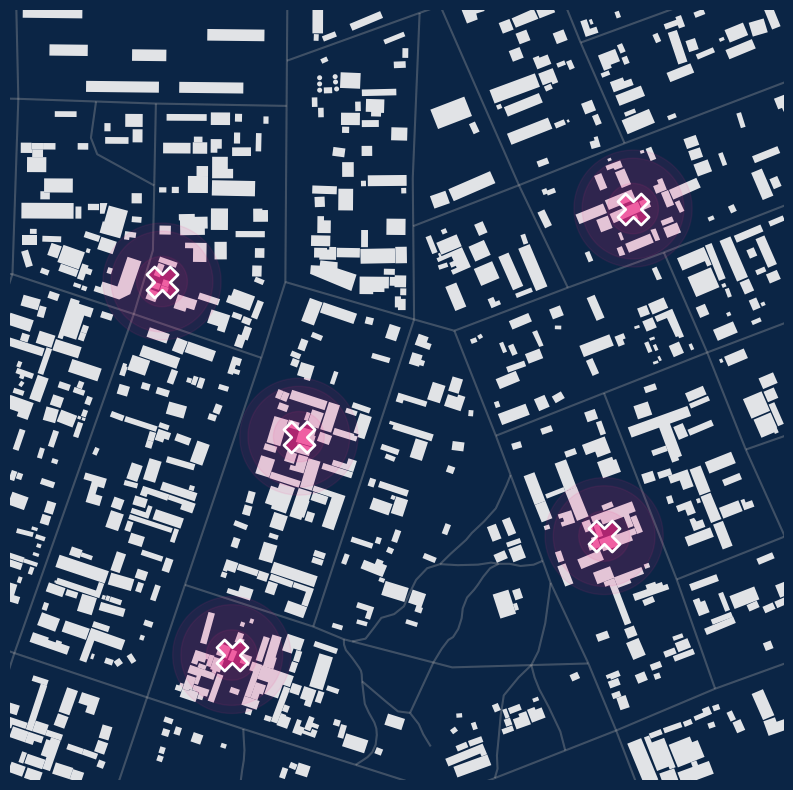

In [103]:
# Optimize the continuous landscape -------------------------------------------
(lndCO, logbookCO) = srv.optimizeTrapsGA(
    lndGA, 
    pop_size='auto', generations=GENS,
    mating_params='auto', mutation_params='auto', selection_params='auto',
    fitFuns={'inner': np.sum, 'outer': np.mean}, verbose=VERBOSE
)
srv.exportLog(logbookCO, OUT_PTH, '{}_LOG_CO'.format(ID))
srv.dumpLandscape(lndCO, OUT_PTH, '{}_LND_CO'.format(ID), fExt='pkl')
# Plot the results ------------------------------------------------------------
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lndDO.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])
fig.savefig(
    os.path.join(OUT_PTH, '{}CO.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

<hr>

# More Information

* [OSMnx Documentation](https://osmnx.readthedocs.io/)
* [OpenStreetMap](https://www.openstreetmap.org)
